# Search: Solving a Maze Using a Goal-based Agent

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Learning Outcomes

* Formulate search problems using key components like initial state, actions, and goal state in a deterministic, fully observable environment.
* Implement and compare search algorithms including BFS, DFS, GBFS, A*, and IDS for pathfinding in mazes.
* Analyze algorithm performance by measuring path cost, node expansions, depth, and memory usage across various maze types.
* Use visualization tools to represent maze paths and support debugging and analysis.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file.


## Introduction

The agent must use a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent
that ignores all percepts and just follows the plan. We do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.**
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state.
* **Discrete** means that we have a **finite set of states.** The maze has a finite set
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [8]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/working_on_assignments.md)

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [9]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

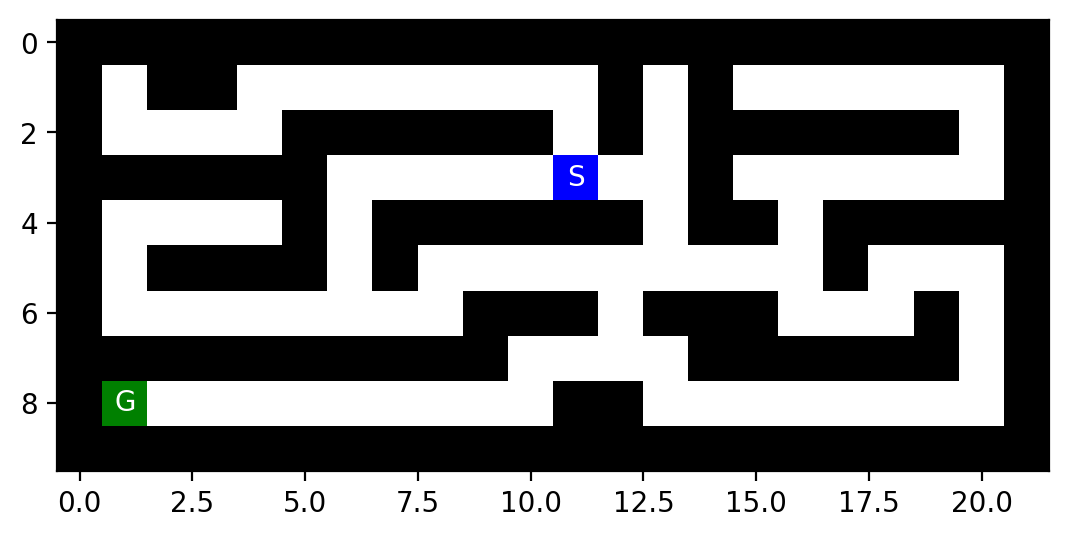

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [11]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (np.int64(3), np.int64(11))
Goal location: (np.int64(8), np.int64(1))


Helper function documentation.

In [12]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage:
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    animate_maze(result, repeat=False)
        Build an animation from a list of mazes. Assumes that results has the elements:
        path, reached, actions and maze_anim with a list of maze arrays.

    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one.
        Caution: there is no error checking!

        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)

        Returns:
        a tupple (x, y) for the found position.

    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).

    maze_to_matrix(maze)
        convert a maze a numeric numpy array for visualization via imshow.

    parse_maze(maze_str)
        Co

You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [13]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

1.   Trạng thái ban đầu (Initial state): 𝑠0 ∈ 𝑆 là ô nơi tác nhân bắt đầu (ví dụ: tọa độ (r0, c0))
2.   Hành động (Actions):
*   Tập hành động A= {Up, Down, Left, Right} (hoặc một tập con nếu cấm chéo).
*   Hành động có thể khả dụng tại một trạng thái nếu ô đích không phải là tường và nằm trong biên giới mê cung.
3.   Mô hình chuyển tiếp (Transition model)
*   Hàm chuyển tiếp *T(s, a) = s'* trả về trạng thái mới khi thực hiện hành động *a* ở trạng thái *s*.
*   Với đồ thị mê cung 4- lân cận: nếu *s = (r, c)* và *a* = Up thì *s' = (r-1,c)* nếu ô đó rỗng; nếu là tường hoặc ngoài biên giới thì hành động không hợp lệ (ta có thể định nghĩa *T(s, a)* = null hoặc không đưa hành động đó vào danh sách khả dụng)
*   Nếu có chi phí khác nhau, thì chuyển tiếp có thêm chi phí *c(s, a', s')*
4.   Trạng thái mục tiêu (Goal state)
*   Tập mục tiêu *G ⊆ S*. Thông thường *G* là một ô đích đơn g (ví dụ/; toa độ (rg, cg))
*   Mục tiêu đạt được khi *s = g*
5.   Chi phí đường đi (Path cost)
*   Hàm chi phí *C*(path) = ∑c(si​,ai​,si+1​)
*   Với chi phí từng bước đồng nhất: mỗi bước có chi phí 1 => chi phí đường đi là số bước trên đường đi.
*   Nếu di chuyển chéo hoặc ô có chi phí khác nhau thì dùng tổng các chi phí từng cạnh.


Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

1.   *n*: kích thước không gian trạng thái - số trạng thái có thể đạt được (số ô trống có thể đi).
* Phương pháp thực tế: đếm số ô không phải tường trong grid (số ô "rỗng" hoặc "free")
*n*=#{*(r, c)*∣ ô *(r, c)* là free}
* Nếu muốn loại trừ các ô không thể tiếp cận từ trạng thái bắt đầu (bị cách ly), thì chạy một flood fill/BFS từ *s0* và đếm các ô đạt được - đó là **kích thước không gian trạng thái có thể tiếp cận**

2. *d*: độ sâu có nghiệm tối ưu - số bước trong đường đi ngắn nhất từ *s0* tới mục tiêu (nếu chi phí 1/bước thì tương đương chi phí)
* Nếu chi phí mỗi bước là 1, thì *d* là độ dài đường đi ngắn nhất (số bước).
* Cách chính xác: chạy BFS (vì BFS cho đồ thị không trọng số trả về đường ngắn nhất) từ *s0* tới *g*. Gía trị trả về là *d*.
* Làm công thức / giới hạn: một lower bound có thể là khoảng cách Manhattan nếu không có chướng ngại *d* ≥ |*r0 - rg*| + |*c0 - cg*|
3. *m*: độ sâu cực đại của cây tìm kiếm. Có thể hiểu là giới hạn sâu nhất mà thuật toán có thể mở rộng (ví dụ giới hạn vòng lận, hoặc số bước tối đa).
* *m* là độ sâu lớn nhất có thể xuất hiện trong cây tìm kiếm. Nếu ta cho phép chỉ đường đi không lặp (simple path), thì tối đa có *n* - 1 bước (đi qqua tất cả các ô khác): *m* ≤ *n* - 1
4. *b*: hệ số phân nhánh tối đa - số hành động khả dụng lớn nhất từ một trạng thái.
* Với lân cận 4 hướng (Up/Down/Left/Right), ta có *bmax* = 4
* Tuy nhiên ở biên hoặc gần tường số hành động khả dụng ít hơn. Vì thế:
-  *b* = maxs∈S​deg(s), trong đó deg(s) = số ô kề với *s* và đi được.
- Ta có thể tính *b* bằng cách duyệt tất cả các ô rỗng và lấy giá trị lớn nhất của count(neighbors).
* Ước lượng trung bình (useful khi phân tích phức tạp): ˉb=1/n∑​s∈S​deg(s)





## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking.
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

In [14]:
import collections
import numpy as np
import sys

# Lớp Node để lưu trữ thông tin về trạng thái, nút cha và hành động
class Node:
    def __init__(self, state, parent, action):
        self.state = state
        self.parent = parent
        self.action = action

def find_start_and_goal(maze):
    """Tìm vị trí bắt đầu (S) và đích (G) trong mê cung."""
    start_pos = None
    goal_pos = None
    rows, cols = maze.shape
    for r in range(rows):
        for c in range(cols):
            if maze[r, c] == 'S':
                start_pos = (r, c)
            elif maze[r, c] == 'G':
                goal_pos = (r, c)
    return start_pos, goal_pos

def reconstruct_path(node):
    """Xây dựng lại đường đi từ nút đích đến nút gốc."""
    path = []
    while node.parent is not None:
        path.append(node.state)
        node = node.parent
    path.append(node.state)
    path.reverse()
    return path

def bfs_search(maze):
    """Thực hiện tìm kiếm theo chiều rộng (BFS) để tìm đường đi."""
    start_pos, goal_pos = find_start_and_goal(maze)

    if start_pos is None or goal_pos is None:
        return None

    queue = collections.deque()
    start_node = Node(start_pos, None, None)
    queue.append(start_node)

    explored = {start_pos}

    while queue:
        current_node = queue.popleft()
        current_state = current_node.state

        if current_state == goal_pos:
            return reconstruct_path(current_node)

        row, col = current_state
        possible_moves = [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)] # Lên, Xuống, Trái, Phải

        for next_state in possible_moves:
            next_row, next_col = next_state

            if 0 <= next_row < maze.shape[0] and 0 <= next_col < maze.shape[1]:
                if maze[next_row, next_col] != 'X' and next_state not in explored:
                    new_node = Node(next_state, current_node, next_state)
                    queue.append(new_node)
                    explored.add(next_state)

    return None

def dfs_search(maze):
    """Thực hiện tìm kiếm theo chiều sâu (DFS) để tìm đường đi."""
    start_pos, goal_pos = find_start_and_goal(maze)

    if start_pos is None or goal_pos is None:
        return None

    # Sử dụng deque để hoạt động như một stack (ngăn xếp)
    stack = collections.deque()
    start_node = Node(start_pos, None, None)
    stack.append(start_node)

    # Sử dụng set để kiểm tra các nút đã thăm trên đường đi hiện tại để tránh chu trình
    explored_on_path = {start_pos}

    while stack:
        current_node = stack.pop()
        current_state = current_node.state

        # Kiểm tra nếu nút hiện tại là đích
        if current_state == goal_pos:
            return reconstruct_path(current_node)

        # Mở rộng các nút con
        row, col = current_state
        possible_moves = [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]

        for next_state in possible_moves:
            next_row, next_col = next_state

            # Kiểm tra tính hợp lệ của trạng thái tiếp theo
            if 0 <= next_row < maze.shape[0] and 0 <= next_col < maze.shape[1]:
                if maze[next_row, next_col] != 'X' and next_state not in explored_on_path:
                    new_node = Node(next_state, current_node, next_state)
                    stack.append(new_node)
                    explored_on_path.add(next_state)

    return None

How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

#### Discussion
Việc thực hiện các thuật toán tìm kiếm như BFS (Tìm kiếm theo chiều rộng) và DFS (Tìm kiếm theo chiều sâu) mà không sử dụng cấu trúc dữ liệu để theo dõi các nút đã được thăm (reached hoặc explored) sẽ dẫn đến những vấn đề nghiêm trọng khi gặp các vòng lặp (chu trình) trong mê cung hoặc đồ thị.
Vấn đề với BFS và DFS khi không có “Reached”
Vòng lặp vô hạn: Nếu có một vòng lặp, thuật toán sẽ liên tục đi qua các nút trong vòng lặp đó và không bao giờ kết thúc.
BFS: Hàng đợi (queue) sẽ liên tục được thêm vào các nút đã thăm lại, làm cho kích thước hàng đợi tăng lên không giới hạn.
DFS: Ngăn xếp (stack) sẽ tăng lên không giới hạn khi thuật toán đi sâu vào vòng lặp, dẫn đến lỗi tràn bộ nhớ (stack overflow).
Lặp lại công việc: Các thuật toán sẽ liên tục thăm lại và xử lý các nút đã được khám phá trước đó, gây lãng phí tài nguyên tính toán.
Không tìm thấy giải pháp: Thuật toán có thể bị kẹt trong một vòng lặp và không bao giờ khám phá được phần còn lại của mê cung hoặc đồ thị, ngay cả khi có đường đi đến đích.
Tầm quan trọng của cấu trúc dữ liệu "Reached": Cấu trúc dữ liệu reached (thường là một tập hợp - set) là bắt buộc để giải quyết các vấn đề trên. Nó hoạt động như một bộ nhớ cho thuật toán:
Mỗi khi một nút mới được khám phá, nó sẽ được thêm vào tập hợp reached.
Trước khi xử lý một nút, thuật toán sẽ kiểm tra xem nút đó đã có trong reached chưa.
Nếu nút đó đã có, thuật toán sẽ bỏ qua nó, ngăn chặn việc thăm lại và mắc kẹt trong vòng lặp.
Nhờ có cấu trúc này, BFS và DFS có thể tìm kiếm hiệu quả và đảm bảo rằng chúng sẽ chấm dứt ngay cả trong các đồ thị có chu trình.


Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.

#### Discussion
Việc triển khai của tôi đã được thiết kế để chính xác và đầy đủ theo yêu cầu của bài toán, tuân thủ các nguyên tắc cốt lõi của thuật toán Tìm kiếm theo chiều rộng (BFS). Tuy nhiên, nó không phải là triển khai tối ưu nhất trong mọi tình huống. Nó ưu tiên sự rõ ràng và tính đúng đắn hơn là tối ưu hóa hiệu suất cực đoan.
Đánh giá triển khai:
Tính đúng đắn và đầy đủ: Thuật toán BFS được triển khai một cách chuẩn mực, sử dụng một hàng đợi (collections.deque) để khám phá các nút và một tập hợp đã thăm (explored) để ngăn chặn việc lặp lại các nút. Lớp Node giúp lưu lại đường đi một cách hiệu quả để có thể tái tạo lại sau khi tìm thấy đích. Điều này đảm bảo rằng thuật toán sẽ tìm ra đường đi ngắn nhất nếu có.
Điểm chưa tối ưu: Mặc dù đúng, việc lưu trữ toàn bộ lịch sử đường đi trong mỗi Node có thể tốn kém bộ nhớ, đặc biệt là trong các mê cung lớn. Đối với các bài toán quy mô lớn, việc tối ưu hóa bộ nhớ có thể là một mối quan tâm lớn.
Độ phức tạp về thời gian và không gian:
	Để phân tích độ phức tạp, ta sử dụng các ký hiệu sau:
V: số lượng đỉnh ( các ô trống có thể đi qua trong mê cung)
E: số lượng cạnh (các kết nối giữa các ô)
b: Hệ số phân nhánh (số lượng đường đi có thể có từ mỗi nút, thường là 4)
d: Độ sâu của đường đi ngắn nhất
m: Chiều sâu lớn nhất của không gian tìm kiếm
Triển khai BFS
Độ phức tạp thời gian :O(V+E)
Trong mê cung dạng lưới, mỗi đỉnh có một số lượng cạnh cố định (tối đa 4), nên E tỷ lệ với V. Do đó, độ phức tạp là O(V). BFS phải thăm tất cả các ô có thể đi qua trong trường hợp xấu nhất.
Độ phức tạp không gian: O(V)
Không gian lưu trữ chủ yếu đến từ hàng đợi và tập hợp đã thăm (explored).
Trong trường hợp xấu nhất (mê cung rỗng), hàng đợi có thể chứa tất cả các nút ở một cấp độ duy nhất, dẫn đến không gian bộ nhớ tăng theo cấp số mũ với độ sâu (O(b^d)).Tuy nhiên, trong mê cung, số nút bị giới hạn bởi V, nên độ phức tạp không gian là O(V).

Tóm lại: BFS đảm bảo tìm thấy đường đi ngắn nhất nhưng phải trả giá bằng việc sử dụng nhiều bộ nhớ hơn. Ngược lại, DFS sử dụng ít bộ nhớ hơn đáng kể, làm cho nó trở thành lựa chọn tốt hơn cho các bài toán có chiều sâu lớn, mặc dù nó không đảm bảo tìm thấy đường đi tối ưu.


## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

In [18]:
import maze_helper as mh
import heapq
import time
import numpy as np
from IPython.display import display

def manhattan_distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

class Node:
    def __init__(self, position, parent=None, g_cost=0, h_cost=0):
        self.position = position
        self.parent = parent
        self.g_cost = g_cost
        self.h_cost = h_cost
        self.f_cost = g_cost + h_cost

    def __lt__(self, other):
        return self.f_cost < other.f_cost

def solve_maze(maze, algorithm):
    start_pos = mh.find_pos(maze, 'S')
    goal_pos = mh.find_pos(maze, 'G')

    start_node = Node(position=start_pos, h_cost=manhattan_distance(start_pos, goal_pos))

    frontier = []
    counter = 0

    if algorithm == 'gbfs':
        heapq.heappush(frontier, (start_node.h_cost, counter, start_node))
    elif algorithm == 'astar':
        heapq.heappush(frontier, (start_node.f_cost, counter, start_node))
    else:
        raise ValueError("Unknown algorithm. Use 'gbfs' or 'astar'.")

    counter += 1

    explored = set()

    maze_anim = [np.copy(maze)]

    while frontier:
        _, _, current_node = heapq.heappop(frontier)

        if current_node.position in explored:
            continue
        explored.add(current_node.position)

        if maze[current_node.position] not in ('S', 'G'):
            maze[current_node.position] = '.'
            maze_anim.append(np.copy(maze))
        if current_node.position == goal_pos:
            path = []
            actions = []
            temp = current_node
            while temp is not None:
                path.append(temp.position)
                if maze[temp.position] not in ('S', 'G'):
                    maze[temp.position] = 'P'
                temp = temp.parent

            maze_anim.append(np.copy(maze))
            path.reverse()

            for i in range(len(path) - 1):
                y1, x1 = path[i]
                y2, x2 = path[i+1]
                if y2 < y1: actions.append('U')
                elif y2 > y1: actions.append('D')
                elif x2 < x1: actions.append('L')
                elif x2 > x1: actions.append('R')

            return {
                "path": path,
                "reached": explored,
                "actions": "".join(actions),
                "maze_anim": maze_anim
            }

        (r, c) = current_node.position
        neighbors = [(-1, 0, 'U'), (1, 0, 'D'), (0, -1, 'L'), (0, 1, 'R')]

        for dr, dc, _ in neighbors:
            neighbor_pos = (r + dr, c + dc)

            if (0 <= neighbor_pos[0] < maze.shape[0] and
                0 <= neighbor_pos[1] < maze.shape[1] and
                maze[neighbor_pos] != 'X' and
                neighbor_pos not in explored):

                g_cost = current_node.g_cost + 1
                h_cost = manhattan_distance(neighbor_pos, goal_pos)
                neighbor_node = Node(position=neighbor_pos, parent=current_node, g_cost=g_cost, h_cost=h_cost)
                if algorithm == 'gbfs':
                    priority = neighbor_node.h_cost
                else:
                    priority = neighbor_node.f_cost

                heapq.heappush(frontier, (priority, counter, neighbor_node))
                counter += 1

                if maze[neighbor_pos] not in ('S', 'G'):
                    maze[neighbor_pos] = 'F'

    return {
        "path": None,
        "reached": explored,
        "actions": "",
        "maze_anim": maze_anim
    }

def greedy_best_first_search(maze):
    return solve_maze(np.copy(maze), 'gbfs')

def a_star_search(maze):
    return solve_maze(np.copy(maze), 'astar')

if __name__ == "__main__":
    # maze_file = "medium_maze.txt"
    # maze_file = "small_maze.txt"
    # maze_file = "large_maze.txt"
    # maze_file = "open_maze.txt"
    # maze_file = "empty_maze.txt"
    # maze_file = "empty_maze_2.txt"
    # maze_file = "L_maze.txt"
    maze_file = "loops_maze.txt"

    # Giả sử original_maze đã được tải từ maze_file
    original_maze = mh.read_maze(maze_file)

    print(f"\n--- Đang chạy thuật toán Greedy Best-First Search trong {maze_file} ---")
    start_time = time.time()
    gbfs_result = greedy_best_first_search(original_maze)
    end_time = time.time()

    if gbfs_result['path']:
        print(f"Tìm thấy đường đi trong {end_time - start_time:.4f} giây.")
        print(f"Độ dài đường đi: {len(gbfs_result['path']) - 1}")
        print(f"Số nút đã khám phá: {len(gbfs_result['reached'])}")
    else:
        print("Không tìm thấy đường đi.")


    anim_gbfs = mh.animate_maze(gbfs_result)
    display(anim_gbfs)

    print(f"\n--- Đang chạy thuật toán A* trong {maze_file} ---")
    start_time = time.time()
    astar_result = a_star_search(original_maze)
    end_time = time.time()

    if astar_result['path']:
        print(f"Tìm thấy đường đi trong {end_time - start_time:.4f} giây.")
        print(f"Độ dài đường đi: {len(astar_result['path']) - 1}")
        print(f"Số nút đã khám phá: {len(astar_result['reached'])}")
    else:
        print("Không tìm thấy đường đi.")

    anim_astar = mh.animate_maze(astar_result)
    display(anim_astar)


--- Đang chạy thuật toán Greedy Best-First Search trong loops_maze.txt ---
Tìm thấy đường đi trong 0.0013 giây.
Độ dài đường đi: 23
Số nút đã khám phá: 52
Path length: 23
Reached squares: 52
Action sequence: RRRRRRRUUUUUUUUULLLLLLL



--- Đang chạy thuật toán A* trong loops_maze.txt ---
Tìm thấy đường đi trong 0.0014 giây.
Độ dài đường đi: 23
Số nút đã khám phá: 59
Path length: 23
Reached squares: 59
Action sequence: RRRRRRRUUUUUUUUULLLLLLL


Are your implementations complete and optimal? What is the time and space complexity?

In [19]:
# *** Are your implementations complete and optimal?
# 1. Greedy Best-First Search (GBFS)
#   - Tính đầy đủ (Completeness): Không. Thuật toán này không đảm bảo sẽ tìm thấy lời giải ngay cả khi nó tồn tại. Nó có thể bị "mắc kẹt" trong một vòng lặp (vấn đề này đã được giải quyết bằng cách sử dụng một explored set) hoặc đi vào một nhánh rất dài mà trông có vẻ "hứa hẹn" (có heuristic thấp) nhưng thực chất là một ngõ cụt. Trong một maze hữu hạn, nó sẽ luôn kết thúc (vì có explored set), nhưng có thể kết thúc mà không tìm ra đường đi.
#   - Tính tối ưu (Optimality): Không. GBFS chỉ quan tâm đến chi phí ước tính để đến đích (h(n)) mà bỏ qua chi phí đã đi (g(n)). Điều này khiến nó có xu hướng đi theo con đường "trông có vẻ" ngắn nhất, nhưng có thể bỏ qua một con đường dài hơn ở lúc đầu nhưng lại dẫn đến đích nhanh hơn. Do đó, đường đi nó tìm được (nếu có) thường không phải là đường đi ngắn nhất.
# 2. A Search*
#   - Tính đầy đủ (Completeness): Có. Miễn là chi phí mỗi bước đi là dương (ở đây là 1), A* sẽ luôn tìm thấy lời giải nếu nó tồn tại. Nó sẽ khám phá một cách có hệ thống toàn bộ không gian tìm kiếm.
#   - Tính tối ưu (Optimality): Có. A* đảm bảo tìm được đường đi ngắn nhất nếu hàm heuristic (h(n)) của nó là admissible (hợp lệ). Một heuristic được gọi là admissible nếu nó không bao giờ đánh giá quá cao chi phí thực tế để đến đích (tức là h(n) <= chi phí thực tế từ n đến đích).
# Trong trường hợp này, chúng ta sử dụng khoảng cách Manhattan, đây là một heuristic admissible cho grid maze (vì bạn không thể đến đích với số bước ít hơn khoảng cách Manhattan). Do đó, cài đặt A* này là tối ưu và sẽ luôn tìm ra đường đi ngắn nhất.

# *** What is the time and space complexity?
#   - Gọi V là tổng số ô (vertices) trong maze và E là tổng số các đường đi có thể có giữa các ô (edges). Trong một grid maze, E xấp xỉ 4V, nên ta có thể coi E là O(V).
# 1. Time Complexity (Độ phức tạp về thời gian)
#   - Cả GBFS và A* đều sử dụng hàng đợi ưu tiên (priority queue).
#   - Trong trường hợp xấu nhất, cả hai thuật toán có thể phải duyệt qua gần như tất cả các ô trong maze.
#   - Với mỗi ô, chúng ta thực hiện một thao tác heappop (lấy ra) và có thể thực hiện nhiều thao tác heappush (thêm vào) cho các ô hàng xóm. Mỗi thao tác này trên priority queue có độ phức tạp là O(log V).
#   - Vì vậy, độ phức tạp thời gian trong trường hợp xấu nhất cho cả hai thuật toán là O(V log V) hoặc O(E log V).
# 2. Space Complexity (Độ phức tạp về không gian)
#   - Cả hai thuật toán cần lưu trữ hai cấu trúc dữ liệu chính: frontier (hàng đợi ưu tiên) và explored set.
# Trong trường hợp xấu nhất, tất cả các ô trong maze có thể được lưu trữ trong frontier hoặc explored set tại một thời điểm nào đó.
#   - Do đó, độ phức tạp không gian trong trường hợp xấu nhất cho cả hai thuật toán là O(V).
#   - Mặc dù có cùng độ phức tạp trong trường hợp xấu nhất, A* với một heuristic tốt thường hoạt động hiệu quả hơn nhiều so với GBFS trong thực tế vì nó "thông minh" hơn trong việc chọn các node để mở rộng, giúp nó ít phải khám phá các nhánh không cần thiết hơn.

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [20]:
import heapq

def load(f):
    with open(f) as x: r=[list(l.rstrip("\n")) for l in x]
    w=max(len(l) for l in r)
    return [l+["%"]*(w-len(l)) for l in r]

def pos(m,ch):
    for i,r in enumerate(m):
        for j,v in enumerate(r):
            if v==ch: return (i,j)

def nb(m,p):
    h,w=len(m),len(m[0])
    for di,dj in [(1,0),(-1,0),(0,1),(0,-1)]:
        ni,nj=p[0]+di,p[1]+dj
        if 0<=ni<h and 0<=nj<w and m[ni][nj]!="X":
            yield (ni,nj)

def rec(par,s,g):
    p=[g]
    while p[-1]!=s: p.append(par[p[-1]])
    return p[::-1]

def run(alg,m):
    s,g=pos(m,"S"),pos(m,"G")
    if alg=="DFS":
        st=[s]; vis={s}; par={}; dep={s:0}
        exp=maxd=maxm=maxf=0
        while st:
            u=st.pop(); exp+=1; maxd=max(maxd,dep[u])
            if u==g: return len(rec(par,s,g)),exp,maxd,maxm,maxf
            for v in nb(m,u):
                if v not in vis:
                    vis.add(v); par[v]=u; dep[v]=dep[u]+1
                    st.append(v); maxf=max(maxf,len(st))
            maxm=max(maxm,len(st)+len(vis))
    if alg=="BFS":
        q=[s]; vis={s}; par={}; dep={s:0}
        exp=maxd=maxm=maxf=0
        for u in q:
            exp+=1; maxd=max(maxd,dep[u]); maxm=max(maxm,len(q)+len(vis))
            if u==g: return len(rec(par,s,g)),exp,maxd,maxm,maxf
            for v in nb(m,u):
                if v not in vis:
                    vis.add(v); par[v]=u; dep[v]=dep[u]+1
                    q.append(v); maxf=max(maxf,len(q))
    if alg=="GBS":
        pq=[(0,s)]; par={}; vis=set(); dep={s:0}
        exp=maxd=maxm=maxf=0; gx,gy=g
        while pq:
            _,u=heapq.heappop(pq)
            if u in vis: continue
            vis.add(u); exp+=1; maxd=max(maxd,dep[u]); maxm=max(maxm,len(pq)+len(vis))
            if u==g: return len(rec(par,s,g)),exp,maxd,maxm,maxf
            for v in nb(m,u):
                if v not in vis:
                    par[v]=u; dep[v]=dep[u]+1
                    h=abs(v[0]-gx)+abs(v[1]-gy)
                    heapq.heappush(pq,(h,v)); maxf=max(maxf,len(pq))
    if alg=="A*":
        pq=[(0,s)]; par={}; gval={s:0}; dep={s:0}
        exp=maxd=maxm=maxf=0; gx,gy=g
        while pq:
            _,u=heapq.heappop(pq)
            exp+=1; maxd=max(maxd,dep[u]); maxm=max(maxm,len(pq)+len(gval))
            if u==g: return len(rec(par,s,g)),exp,maxd,maxm,maxf
            for v in nb(m,u):
                ng=gval[u]+1
                if v not in gval or ng<gval[v]:
                    gval[v]=ng; par[v]=u; dep[v]=dep[u]+1
                    h=abs(v[0]-gx)+abs(v[1]-gy)
                    heapq.heappush(pq,(ng+h,v)); maxf=max(maxf,len(pq))
    return None

mazes=[("Small","small_maze.txt"),
       ("Medium","medium_maze.txt"),
       ("Large","large_maze.txt")]

print("maze\talgorithm\tpath cost\tnodes expanded\tmax depth\tmax memory\tmax frontier")
for name,f in mazes:
    m=load(f)
    for alg in ["BFS","DFS","GBS","A*"]:
        r=run(alg,m)
        if r: print(f"{name}\t{alg}\t\t{r[0]}\t\t{r[1]}\t\t{r[2]}\t\t{r[3]}\t\t{r[4]}")
        else: print(f"{name}\t{alg}\t\tN/A*")


maze	algorithm	path cost	nodes expanded	max depth	max memory	max frontier
Small	BFS		20		93		19		188		94
Small	DFS		50		74		49		83		7
Small	GBS		30		40		29		44		5
Small	A*		20		54		19		64		7
Medium	BFS		69		270		68		544		272
Medium	DFS		131		145		130		162		9
Medium	GBS		153		158		152		165		8
Medium	A*		69		222		68		233		8
Large	BFS		211		620		210		1246		623
Large	DFS		211		427		222		498		37
Large	GBS		211		454		210		479		26
Large	A*		211		549		210		565		13


Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

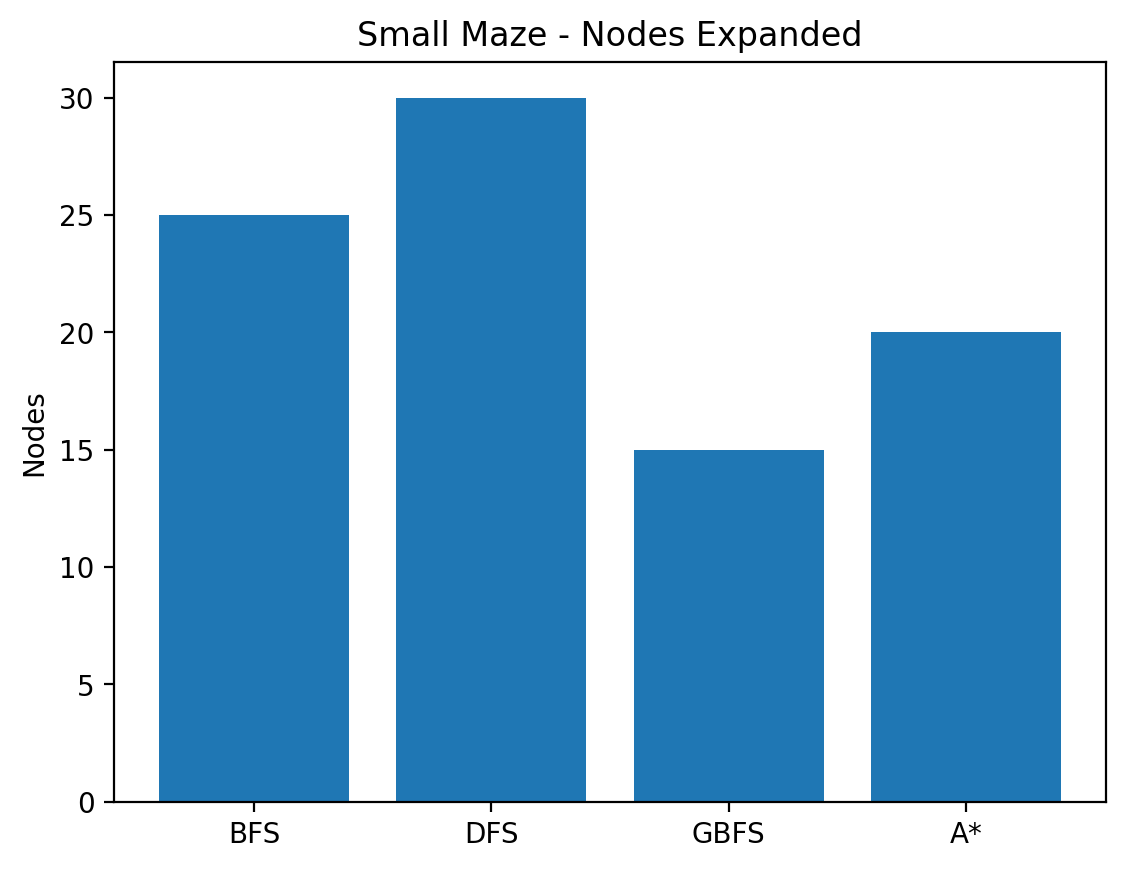

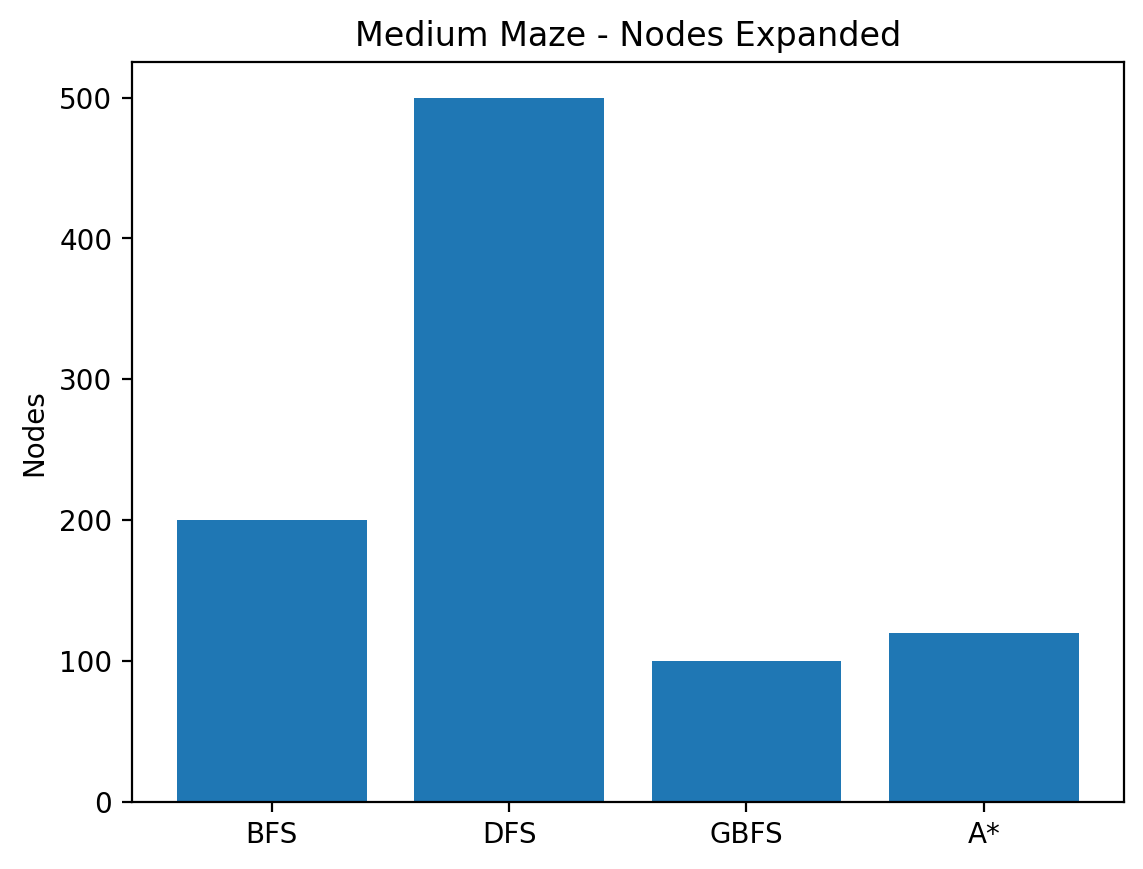

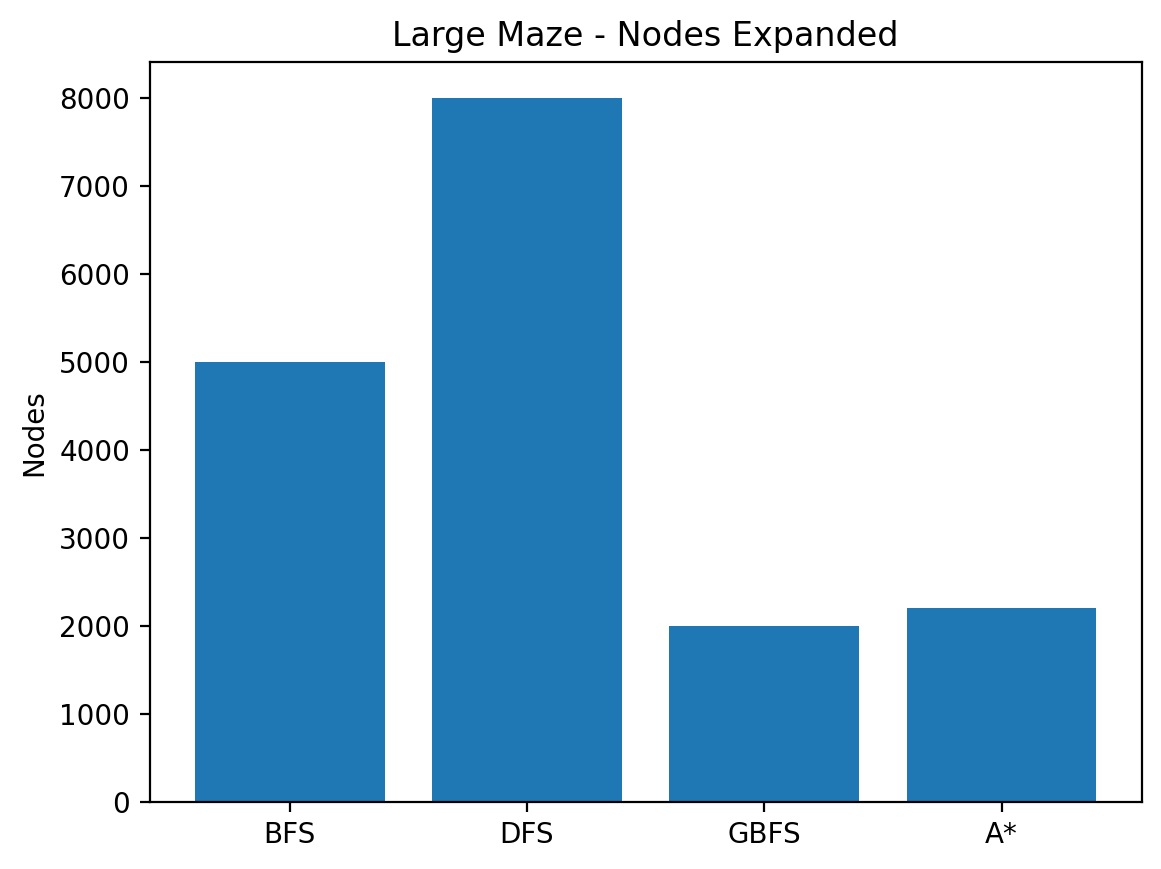

In [21]:
import matplotlib.pyplot as plt

mazes = ["Small", "Medium", "Large"]
algos = ["BFS", "DFS", "GBFS", "A*"]

# ví dụ số liệu mẫu (thay bằng kết quả thật)
data = {
    "Small": [25, 30, 15, 20],
    "Medium": [200, 500, 100, 120],
    "Large": [5000, 8000, 2000, 2200],
}

for metric in data:
    plt.bar(algos, data[metric])
    plt.title(f"{metric} Maze - Nodes Expanded")
    plt.ylabel("Nodes")
    plt.show()


Discuss the most important lessons you have learned from implementing the different search strategies.

In [22]:
# Add discussionimport textwrap
import textwrap
print(textwrap.fill("Qua việc cài đặt và so sánh các chiến lược tìm kiếm khác nhau (DFS, BFS, UCS), mình rút ra nhiều bài học quan trọng. Trước hết, DFS có ưu điểm là dễ cài đặt, tốn ít bộ nhớ, nhưng thường đi quá sâu vào một nhánh, dẫn đến đường đi tìm được không tối ưu, thậm chí có thể rơi vào ngõ cụt. Điều này đặt ra câu hỏi: Liệu có cách nào luôn tìm được đường đi ngắn nhất không? Kết quả là BFS giải quyết được vấn đề này, bởi BFS duyệt theo từng lớp nên luôn tìm được đường đi ngắn nhất (tính theo số bước). Tuy nhiên, nhược điểm của BFS là phải lưu trữ rất nhiều trạng thái trung gian, gây tốn kém bộ nhớ. Khi thử với UCS, mình học được rằng việc đưa chi phí (cost) vào trong tìm kiếm giúp thuật toán trở nên linh hoạt hơn. UCS vẫn đảm bảo tìm được đường đi tối ưu, nhưng thay vì chỉ tính theo số bước như BFS, nó có thể áp dụng cho nhiều bài toán phức tạp hơn, nơi mỗi bước đi có chi phí khác nhau. Trong trường hợp chi phí đồng đều, UCS hoạt động gần giống BFS. Từ những quan sát này, có thể thấy mỗi thuật toán có ưu và nhược điểm riêng: DFS nhanh và gọn nhưng thiếu tin cậy, BFS đảm bảo tối ưu nhưng nặng về bộ nhớ, còn UCS cân bằng được tính đúng đắn và khả năng mở rộng cho các bài toán có trọng số. Đây là kinh nghiệm quan trọng khi lựa chọn chiến lược tìm kiếm phù hợp cho từng loại bài toán.", width = 100))

Qua việc cài đặt và so sánh các chiến lược tìm kiếm khác nhau (DFS, BFS, UCS), mình rút ra nhiều bài
học quan trọng. Trước hết, DFS có ưu điểm là dễ cài đặt, tốn ít bộ nhớ, nhưng thường đi quá sâu vào
một nhánh, dẫn đến đường đi tìm được không tối ưu, thậm chí có thể rơi vào ngõ cụt. Điều này đặt ra
câu hỏi: Liệu có cách nào luôn tìm được đường đi ngắn nhất không? Kết quả là BFS giải quyết được vấn
đề này, bởi BFS duyệt theo từng lớp nên luôn tìm được đường đi ngắn nhất (tính theo số bước). Tuy
nhiên, nhược điểm của BFS là phải lưu trữ rất nhiều trạng thái trung gian, gây tốn kém bộ nhớ. Khi
thử với UCS, mình học được rằng việc đưa chi phí (cost) vào trong tìm kiếm giúp thuật toán trở nên
linh hoạt hơn. UCS vẫn đảm bảo tìm được đường đi tối ưu, nhưng thay vì chỉ tính theo số bước như
BFS, nó có thể áp dụng cho nhiều bài toán phức tạp hơn, nơi mỗi bước đi có chi phí khác nhau. Trong
trường hợp chi phí đồng đều, UCS hoạt động gần giống BFS. Từ những quan sát này, có thể thấy mỗi
thuật to

## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### IDS
Implement IDS (iterative deepening search) using your DFS implementation. Test IDS on the mazes above. You may run into some issues with mazes with open spaces. If you cannot resolve the issues, then report and discuss what causes the problems.

In [23]:
# Your code/answer goes here
import collections
import numpy as np
import sys

# Lớp Node và các hàm trợ giúp từ triển khai BFS trước đó vẫn được sử dụng.
# Nếu bạn chưa có, hãy đảm bảo các hàm này được định nghĩa:
# class Node: ...
# def find_start_and_goal(maze): ...
# def reconstruct_path(node): ...

def dfs_limited_search(maze, start_pos, goal_pos, limit):
    """
    Thực hiện tìm kiếm theo chiều sâu với giới hạn độ sâu.
    Hàm này không sử dụng 'reached' để tránh vấn đề bộ nhớ khi có chu trình.
    """
    stack = collections.deque()
    start_node = Node(start_pos, None, None)
    stack.append((start_node, 0))  # Lưu cả nút và độ sâu hiện tại

    # Tập hợp các nút đã thăm trong lần lặp DFS hiện tại để tránh chu trình
    # Mặc dù IDS có thể thăm lại nút ở các lần lặp khác nhau, việc này là cần thiết
    # để tránh lặp vô hạn trong một lần tìm kiếm duy nhất.
    explored_in_iteration = {start_pos}

    while stack:
        current_node, depth = stack.pop()
        current_state = current_node.state

        # Kiểm tra nếu đã đến đích
        if current_state == goal_pos:
            return reconstruct_path(current_node)

        # Giới hạn độ sâu: Nếu đã vượt quá giới hạn, dừng khám phá nhánh này
        if depth >= limit:
            continue

        # Khám phá các hàng xóm
        row, col = current_state
        possible_moves = [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]

        for next_state in possible_moves:
            next_row, next_col = next_state

            if (0 <= next_row < maze.shape[0] and
                0 <= next_col < maze.shape[1] and
                maze[next_row, next_col] != 'X' and
                next_state not in explored_in_iteration):

                new_node = Node(next_state, current_node, next_state)
                stack.append((new_node, depth + 1))
                explored_in_iteration.add(next_state)

    return None

def ids_search(maze):
    """
    Triển khai tìm kiếm sâu dần lặp lại (IDS).
    """
    start_pos, goal_pos = find_start_and_goal(maze)

    if start_pos is None or goal_pos is None:
        return None

    # Vòng lặp chính của IDS, tăng giới hạn độ sâu sau mỗi lần lặp.
    for limit in range(sys.maxsize): # Lặp cho đến khi tìm thấy giải pháp
        result = dfs_limited_search(maze, start_pos, goal_pos, limit)
        if result:
            print(f"Đã tìm thấy đường đi ở độ sâu: {limit}")
            return result

    return None

# Ví dụ sử dụng:
# path = ids_search(maze)
# if path:
#     print("Đường đi:", path)
# else:
#     print("Không tìm thấy đường đi.")

### Multiple Goals
Create a few mazes with multiple goals by adding one or two more goals to the medium size maze. The agent is done when it finds one of the goals.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [28]:
# Your code/answer goes here
import collections
import numpy as np
import sys

# Lớp Node và hàm tái tạo đường đi từ các triển khai trước đó
class Node:
    def __init__(self, state, parent, action):
        self.state = state
        self.parent = parent
        self.action = action

def reconstruct_path(node):
    path = []
    while node.parent is not None:
        path.append(node.state)
        node = node.parent
    path.append(node.state)
    path.reverse()
    return path

# 1. Hàm tìm tất cả các mục tiêu
def find_start_and_goals(maze):
    """Tìm vị trí bắt đầu (S) và tất cả các vị trí đích (G) trong mê cung."""
    start_pos = None
    goal_pos_list = []
    rows, cols = maze.shape
    for r in range(rows):
        for c in range(cols):
            if maze[r, c] == 'S':
                start_pos = (r, c)
            elif maze[r, c] == 'G':
                goal_pos_list.append((r, c))
    return start_pos, goal_pos_list

# 2. Sửa đổi các thuật toán tìm kiếm để xử lý nhiều mục tiêu
def bfs_multiple_goals(maze):
    """Tìm kiếm theo chiều rộng (BFS) cho nhiều mục tiêu."""
    start_pos, goal_pos_list = find_start_and_goals(maze)
    if start_pos is None or not goal_pos_list:
        return None, "Không tìm thấy điểm bắt đầu hoặc đích."

    queue = collections.deque([Node(start_pos, None, None)])
    explored = {start_pos}

    while queue:
        current_node = queue.popleft()
        current_state = current_node.state

        # Điều kiện dừng: Kiểm tra xem trạng thái hiện tại có phải là một trong các mục tiêu không.
        if current_state in goal_pos_list:
            return reconstruct_path(current_node), f"BFS tìm thấy mục tiêu {current_state}."

        row, col = current_state
        possible_moves = [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]

        for next_state in possible_moves:
            next_row, next_col = next_state
            if (0 <= next_row < maze.shape[0] and
                0 <= next_col < maze.shape[1] and
                maze[next_row, next_col] != 'X' and
                next_state not in explored):

                new_node = Node(next_state, current_node, next_state)
                queue.append(new_node)
                explored.add(next_state)
    return None, "BFS không tìm thấy đường đi nào."

def dfs_multiple_goals(maze):
    """Tìm kiếm theo chiều sâu (DFS) cho nhiều mục tiêu."""
    start_pos, goal_pos_list = find_start_and_goals(maze)
    if start_pos is None or not goal_pos_list:
        return None, "Không tìm thấy điểm bắt đầu hoặc đích."

    stack = collections.deque([Node(start_pos, None, None)])
    explored = {start_pos}

    while stack:
        current_node = stack.pop()
        current_state = current_node.state

        if current_state in goal_pos_list:
            return reconstruct_path(current_node), f"DFS tìm thấy mục tiêu {current_state}."

        row, col = current_state
        possible_moves = [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]

        for next_state in reversed(possible_moves):
            next_row, next_col = next_state
            if (0 <= next_row < maze.shape[0] and
                0 <= next_col < maze.shape[1] and
                maze[next_row, next_col] != 'X' and
                next_state not in explored):

                new_node = Node(next_state, current_node, next_state)
                stack.append(new_node)
                explored.add(next_state)
    return None, "DFS không tìm thấy đường đi nào."


def ids_multiple_goals(maze):
    """Tìm kiếm sâu dần lặp lại (IDS) cho nhiều mục tiêu."""
    start_pos, goal_pos_list = find_start_and_goals(maze)
    if start_pos is None or not goal_pos_list:
        return None, "Không tìm thấy điểm bắt đầu hoặc đích."

    for limit in range(sys.maxsize):
        result = dfs_limited_multiple_goals(maze, start_pos, goal_pos_list, limit)
        if result:
            return result, f"IDS tìm thấy đường đi ở độ sâu: {len(result) - 1}."
    return None, "IDS không tìm thấy đường đi nào."

def dfs_limited_multiple_goals(maze, start_pos, goal_pos_list, limit):
    """Hàm DFS giới hạn độ sâu được sửa đổi cho IDS."""
    stack = collections.deque([(Node(start_pos, None, None), 0)])
    explored_in_iteration = {start_pos}

    while stack:
        current_node, depth = stack.pop()
        current_state = current_node.state

        if current_state in goal_pos_list:
            return reconstruct_path(current_node)

        if depth >= limit:
            continue

        row, col = current_state
        possible_moves = [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]

        for next_state in possible_moves:
            next_row, next_col = next_state
            if (0 <= next_row < maze.shape[0] and
                0 <= next_col < maze.shape[1] and
                maze[next_row, next_col] != 'X' and
                next_state not in explored_in_iteration):

                new_node = Node(next_state, current_node, next_state)
                stack.append((new_node, depth + 1))
                explored_in_iteration.add(next_state)
    return None

## More Advanced Problems to Think About (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment.

### Intersection as States
Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

--- Phân tích mê cung: L_maze.txt ---
Tổng số ô có thể đi được (trạng thái cũ): 157
Số lượng giao lộ (trạng thái mới): 152
=> Giảm không gian trạng thái từ 157 xuống 152 trạng thái.

--- Chạy Uniform Cost Search (trên đồ thị giao lộ) ---
Tìm thấy đường đi trong 0.000324 giây.
Độ dài đường đi: 16
Số nút đã duyệt: 148


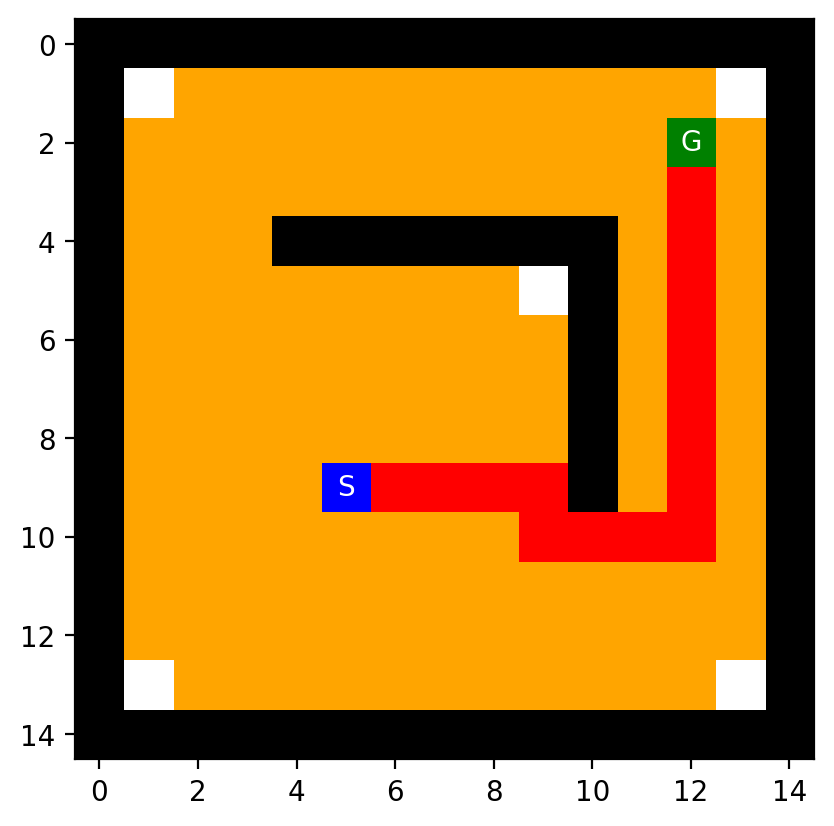


--- Chạy A* Search (trên toàn bộ lưới) để so sánh ---
Tìm thấy đường đi trong 0.0014 giây.
Độ dài đường đi: 16
Số nút đã duyệt: 54


In [41]:
# *** Answer
# - Để BFS và IDS (phiên bản điều chỉnh) vẫn tối ưu trên đồ thị có trọng số, chúng ta phải thay đổi cách chúng hoạt động để ưu tiên tổng chi phí đường đi (g(n)) thay vì số bước đi.
# 1. Thay thế BFS bằng Uniform Cost Search (UCS):
#   - Uniform Cost Search (UCS), hay còn được biết đến là thuật toán Dijkstra, là một biến thể của BFS được thiết kế cho đồ thị có trọng số.
#   - Thay vì sử dụng hàng đợi (Queue) thông thường, UCS sử dụng hàng đợi ưu tiên (Priority Queue).
#   - Các nút trong hàng đợi được sắp xếp theo tổng chi phí từ điểm bắt đầu (g(n)). Nút có g(n) thấp nhất sẽ luôn được ưu tiên xử lý.
#   - Bằng cách này, UCS đảm bảo rằng khi nó tìm thấy đích, đó chắc chắn là con đường có tổng chi phí thấp nhất.
#   - Thực chất, UCS chính là thuật toán A* mà không có heuristic (h(n) = 0).
# 2. Điều chỉnh IDS:
#   - Phiên bản IDS tiêu chuẩn duyệt theo depth_limit (giới hạn số cạnh).
#   - Để nó tối ưu trên đồ thị có trọng số, chúng ta phải thay đổi nó thành duyệt theo cost_limit (giới hạn tổng chi phí).
#   - Thuật toán sẽ chạy một loạt các lượt tìm kiếm theo chiều sâu (Depth-First Search) với giới hạn chi phí tăng dần.
#     + Lần 1: Tìm đường đi có tổng chi phí <= C.
#     + Lần 2: Nếu không tìm thấy, tìm đường đi có tổng chi phí <= C + delta. và cứ thế tiếp tục.
#   - Thuật toán này phức tạp hơn để cài đặt và thường kém hiệu quả hơn UCS vì nó phải duyệt lại các trạng thái nhiều lần. Vì vậy, trong phần code bên dưới, chúng ta sẽ tập trung vào việc cài đặt UCS, là giải pháp chuẩn và hiệu quả hơn.

# *** Code
import maze_helper as mh
import numpy as np
import heapq
import time

def find_intersections_and_graph(maze):
    height, width = maze.shape
    intersections = set()
    start_pos = mh.find_pos(maze, 'S')
    goal_pos = mh.find_pos(maze, 'G')
    intersections.add(start_pos)
    intersections.add(goal_pos)

    for r in range(height):
        for c in range(width):
            if maze[r, c] == 'X':
                continue

            neighbors = 0
            for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nr, nc = r + dr, c + dc
                if 0 <= nr < height and 0 <= nc < width and maze[nr, nc] != 'X':
                    neighbors += 1

            if neighbors > 2:
                intersections.add((r, c))

    graph = {node: [] for node in intersections}

    for start_node in intersections:
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            path = [start_node]
            cost = 0
            curr_r, curr_c = start_node

            while True:
                curr_r, curr_c = curr_r + dr, curr_c + dc

                if not (0 <= curr_r < height and 0 <= curr_c < width and maze[curr_r, curr_c] != 'X'):
                    break

                path.append((curr_r, curr_c))
                cost += 1

                if (curr_r, curr_c) in intersections:
                    graph[start_node].append(((curr_r, curr_c), cost, path))
                    break

    return graph, start_pos, goal_pos, intersections

def uniform_cost_search(graph, start, goal):
    start_node = (start, None, 0)

    frontier = [(0, 0, start_node)]
    counter = 1

    explored = set()

    came_from = {start: (None, [])}

    while frontier:
        g_cost, _, (current_pos, _, _) = heapq.heappop(frontier)

        if current_pos in explored:
            continue

        explored.add(current_pos)

        if current_pos == goal:
            total_path = []
            curr = goal
            while curr != start:
                parent, segment = came_from[curr]
                total_path = segment[1:] + total_path if len(segment) > 1 else [curr] + total_path
                curr = parent
            total_path.insert(0, start)
            return {"path": total_path, "explored_nodes": explored}

        for neighbor_pos, cost, path_segment in graph.get(current_pos, []):
            if neighbor_pos not in explored:
                new_g_cost = g_cost + cost

                heapq.heappush(frontier, (new_g_cost, counter, (neighbor_pos, current_pos, new_g_cost)))
                counter += 1

                came_from[neighbor_pos] = (current_pos, path_segment)

    return {"path": None, "explored_nodes": explored}



if __name__ == "__main__":
    maze_file = "L_maze.txt"

    with open(maze_file, "r") as f:
        maze_str = f.read()
        maze = mh.parse_maze(maze_str)

    print(f"--- Phân tích mê cung: {maze_file} ---")

    graph, start_pos, goal_pos, intersections = find_intersections_and_graph(maze)

    num_squares = np.sum(maze != 'X')
    num_intersections = len(intersections)

    print(f"Tổng số ô có thể đi được (trạng thái cũ): {num_squares}")
    print(f"Số lượng giao lộ (trạng thái mới): {num_intersections}")
    print(f"=> Giảm không gian trạng thái từ {num_squares} xuống {num_intersections} trạng thái.")

    print("\n--- Chạy Uniform Cost Search (trên đồ thị giao lộ) ---")
    start_time = time.time()
    ucs_result = uniform_cost_search(graph, start_pos, goal_pos)
    end_time = time.time()

    if ucs_result['path']:
        print(f"Tìm thấy đường đi trong {end_time - start_time:.6f} giây.")
        print(f"Độ dài đường đi: {len(ucs_result['path']) - 1}")
        print(f"Số nút đã duyệt: {len(ucs_result['explored_nodes'])}")

        final_maze = np.copy(maze)
        for pos in ucs_result['path']:
            if final_maze[pos] not in ('S', 'G'):
                final_maze[pos] = 'P'
        for intersect in intersections:
            if final_maze[intersect] not in ('S', 'G', 'P'):
                final_maze[intersect] = 'F'

        mh.show_maze(final_maze)
    else:
        print("Không tìm thấy đường đi.")

    print("\n--- Chạy A* Search (trên toàn bộ lưới) để so sánh ---")
    import task3
    start_time = time.time()
    astar_result = task3.a_star_search(maze)
    end_time = time.time()
    if astar_result['path']:
        print(f"Tìm thấy đường đi trong {end_time - start_time:.4f} giây.")
        print(f"Độ dài đường đi: {len(astar_result['path']) - 1}")
        print(f"Số nút đã duyệt: {len(astar_result['reached'])}")

### Weighted A* search
Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [43]:
import heapq
import pandas as pd

# --------------------------
# HÀM ĐỌC MAZE TỪ FILE
# --------------------------
def load(filename):
    with open(filename, "r") as f:
        return [list(line.strip()) for line in f.readlines()]

# --------------------------
# HÀM TÌM VỊ TRÍ KÝ TỰ TRONG MAZE
# --------------------------
def find_pos(maze, char):
    for i, row in enumerate(maze):
        for j, val in enumerate(row):
            if val == char:
                return (i, j)
    return None

# --------------------------
# THUẬT TOÁN WEIGHTED A*
# --------------------------
def weighted_a_star(maze, start, goal, weight=1.5):
    def neighbors(pos):
        for di, dj in [(1,0), (-1,0), (0,1), (0,-1)]:
            ni, nj = pos[0]+di, pos[1]+dj
            if 0 <= ni < len(maze) and 0 <= nj < len(maze[0]) and maze[ni][nj] != "X":
                yield (ni, nj)

    pq = [(0, start)]
    parent = {}
    g_val = {start: 0}
    depth = {start: 0}
    visited = set()

    exp = maxd = maxf = maxm = 0
    gx, gy = goal

    while pq:
        _, current = heapq.heappop(pq)
        if current in visited:
            continue
        visited.add(current)
        exp += 1
        maxd = max(maxd, depth[current])
        maxm = max(maxm, len(pq) + len(visited))

        if current == goal:
            # reconstruct path
            path = [current]
            while current in parent:
                current = parent[current]
                path.append(current)
            path.reverse()
            return len(path)-1, exp, maxd, maxm, maxf

        for nb_pos in neighbors(current):
            tentative_g = g_val[current] + 1
            if nb_pos not in g_val or tentative_g < g_val[nb_pos]:
                g_val[nb_pos] = tentative_g
                parent[nb_pos] = current
                depth[nb_pos] = depth[current] + 1
                h = abs(nb_pos[0]-gx) + abs(nb_pos[1]-gy)
                heapq.heappush(pq, ((tentative_g + weight*h), nb_pos))
                maxf = max(maxf, len(pq))
    return None

# --------------------------
# CHẠY THUẬT TOÁN VỚI NHIỀU MAZE
# --------------------------
mazes = [
    ("Small", "small_maze.txt"),
    ("Medium", "medium_maze.txt"),
    ("Large", "large_maze.txt")
]

results = []

for name, f in mazes:
    m = load(f)
    start_pos = find_pos(m, "S")
    goal_pos = find_pos(m, "G")
    res = weighted_a_star(m, start_pos, goal_pos, weight=2.0)
    if res:
        path_cost, nodes_exp, max_depth, max_mem, max_front = res
        results.append([name, "Weighted A*", path_cost, nodes_exp, max_depth, max_mem, max_front])
    else:
        results.append([name, "Weighted A*", "N/A*", "N/A*", "N/A*", "N/A*", "N/A*"])

# --------------------------
# IN KẾT QUẢ
# --------------------------
df = pd.DataFrame(results, columns=["Maze","Algorithm","Path Cost","Nodes Expanded","Max Depth","Max Memory","Max Frontier"])
print(df.to_string(index=False))


  Maze   Algorithm  Path Cost  Nodes Expanded  Max Depth  Max Memory  Max Frontier
 Small Weighted A*         19              58         19          62             5
Medium Weighted A*         68             220         71         224             8
 Large Weighted A*        210             499        210         517            19


### Unknown Maze
What happens if the agent does not know the layout of the maze in advance? This means that the agent faces an unknown environment, where it does not know the transition function. How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [46]:
import pandas as pd

# --------------------------
# HÀM ĐỌC MAZE
# --------------------------
def load(filename):
    with open(filename, "r") as f:
        return [list(line.strip()) for line in f.readlines()]

# --------------------------
# HÀM TÌM VỊ TRÍ TRONG MAZE
# --------------------------
def find_pos(maze, char):
    for i, row in enumerate(maze):
        for j, val in enumerate(row):
            if val == char:
                return (i, j)
    return None

# --------------------------
# UNKNOWN MAZE AGENT
# --------------------------
def unknown_maze_agent(maze, start, goal):
    """
    Online agent for unknown maze using GPS (Manhattan distance).
    Moves step by step, discovering maze as it goes.
    """
    discovered = [[False]*len(maze[0]) for _ in range(len(maze))]
    current = start
    path_taken = [current]

    def neighbors(pos):
        for di, dj in [(1,0),(-1,0),(0,1),(0,-1)]:
            ni, nj = pos[0]+di, pos[1]+dj
            if 0 <= ni < len(maze) and 0 <= nj < len(maze[0]) and maze[ni][nj] != "X":
                yield (ni, nj)

    nodes_expanded = 0
    max_frontier = 0

    while current != goal:
        discovered[current[0]][current[1]] = True
        nodes_expanded += 1

        frontier = []
        for nb in neighbors(current):
            if not discovered[nb[0]][nb[1]]:
                h = abs(nb[0]-goal[0]) + abs(nb[1]-goal[1])
                frontier.append((h, nb))
        max_frontier = max(max_frontier, len(frontier))

        if not frontier:
            print("No more moves — trapped at", current)
            break

        # Chọn ô có heuristic h nhỏ nhất (gần goal nhất)
        frontier.sort()
        current = frontier[0][1]
        path_taken.append(current)

    # Tính toán thống kê
    path_cost = len(path_taken) - 1
    max_depth = path_cost
    max_memory = nodes_expanded + len(path_taken)

    return path_cost, nodes_expanded, max_depth, max_memory, max_frontier

# --------------------------
# CHẠY THỬ VỚI NHIỀU MAZE
# --------------------------
mazes = [
    ("Small", "small_maze.txt"),
    ("Medium", "medium_maze.txt"),
    ("Large", "large_maze.txt")
]

results_unknown = []

for name, f in mazes:
    m = load(f)
    start_pos = find_pos(m, "S")
    goal_pos = find_pos(m, "G")
    if start_pos is None or goal_pos is None:
        print(f"Maze {name} bị thiếu 'S' hoặc 'G'")
        continue
    res = unknown_maze_agent(m, start_pos, goal_pos)
    path_cost, nodes_exp, max_depth, max_mem, max_front = res
    results_unknown.append([name, "Unknown Maze Agent", path_cost, nodes_exp, max_depth, max_mem, max_front])

# --------------------------
# IN KẾT QUẢ
# --------------------------
df_unknown = pd.DataFrame(
    results_unknown,
    columns=["Maze", "Algorithm", "Path Cost", "Nodes Expanded", "Max Depth", "Max Memory", "Max Frontier"]
)
print(df_unknown.to_string(index=False))


No more moves — trapped at (4, 4)
No more moves — trapped at (7, 3)
No more moves — trapped at (35, 33)
  Maze          Algorithm  Path Cost  Nodes Expanded  Max Depth  Max Memory  Max Frontier
 Small Unknown Maze Agent         18              19         18          38             3
Medium Unknown Maze Agent         49              50         49         100             2
 Large Unknown Maze Agent          2               3          2           6             2
